In [0]:
SETUP = True

categories:


id:1

name:ball



id:2

name:goal



id:3

name:pitch



id:4

name:player


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

TensorFlow 2.x selected.


In [0]:
#!pip install tensorflow==2.1

In [3]:
if SETUP:
    !pip install -q -U toai
    
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !pip install -q kaggle
    
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

     |████████████████████████████████| 296kB 12.5MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 552kB 20.2MB/s 
     |████████████████████████████████| 153kB 23.3MB/s 
     |████████████████████████████████| 122kB 31.8MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
0.4.1
2.1.0


In [0]:
print(__import__("tensorflow").__version__)

In [0]:
from toai.imports import *
from toai.image import ImageAugmentor, ImageParser, ImageResizer, ImageDataContainer
from toai.data.utils import split_df
from toai.encode import CategoricalEncoder
from typing import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from glob import glob
from matplotlib.patches import Rectangle
from skimage.transform import resize
import os
from toai.utils import unzip

In [0]:
DATA_DIR = Path("data/football")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp/football")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
if SETUP:
    
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    TEMP_DIR.mkdir(parents=True, exist_ok=True)
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset="ramarlina/soccer-player-and-ball-localization",
        path=DATA_DIR,
        unzip=True,
    )

In [0]:
import csv
import json
import glob
from natsort import index_natsorted, order_by_index

In [0]:
%matplotlib inline

In [0]:
with open(str(DATA_DIR/'annotations_coco.json'),'r') as j:
  contents = json.loads(j.read())

In [0]:
contents = contents['annotations']

In [0]:
df = pd.DataFrame(contents)

In [12]:
df.head(10)

,category_id,id,image_id,iscrowd,segmentation,area,bbox
0,4,0,0,0,"[[783.390625, 1969.44921875, 826.3906288146973...",2064.0,"[783.0, 1969.0, 43.0, 48.0]"
1,4,1,0,0,"[[1140.0, 1984.5, 1110.5, 1984.0, 1111.0, 1940...",1497.0,"[1111.0, 1941.0, 42.0, 44.0]"
2,4,2,0,0,"[[931.818359375, 1605.4000000000015, 998.0, 16...",3300.0,"[932.0, 1605.0, 66.0, 50.0]"
3,4,3,0,0,"[[546.30078125, 1719.69921875, 601.20077819824...",2310.0,"[546.0, 1720.0, 55.0, 42.0]"
4,4,4,0,0,"[[729.6000000000022, 863.2999999999993, 785.79...",3360.0,"[730.0, 863.0, 56.0, 60.0]"
5,4,5,0,0,"[[773.87109375, 1523.943359375, 828.2187690734...",3024.0,"[774.0, 1524.0, 54.0, 56.0]"
6,4,6,0,0,"[[1052.300000000001, 1223.1005859375, 1089.399...",2294.0,"[1052.0, 1223.0, 37.0, 62.0]"
7,4,7,0,0,"[[1909.330078125, 889.22265625, 1945.0, 889.22...",1548.0,"[1909.0, 889.0, 36.0, 43.0]"
8,4,8,0,0,"[[2024.0, 910.5, 1996.0, 910.5, 1995.5, 886.0,...",700.0,"[1996.0, 886.0, 28.0, 25.0]"
9,2,9,0,0,"[[2030.2999999999993, 1999.69921875, 2066.8000...",1480.0,"[2030.0, 2000.0, 37.0, 40.0]"


In [13]:
length = len(df['bbox'][0])
for i, x in enumerate(df['bbox']):
    if len(x) != length:
        print(i)
    else:
      print('ok')
    break

ok


In [0]:
#images =(str(DATA_DIR/'images'))

In [0]:
files = glob.glob(str(DATA_DIR/'images'/'*.jpg'))

In [0]:
filename = pd.DataFrame(files)

In [17]:
filename.head()

,0
0,data/football/images/frame_0373.jpg
1,data/football/images/frame_0559.jpg
2,data/football/images/frame_0334.jpg
3,data/football/images/frame_0155.jpg
4,data/football/images/frame_0603.jpg


In [18]:
len(filename)

626

In [0]:
from natsort import index_natsorted, order_by_index

sort_df = filename.reindex(index=order_by_index(filename.index, index_natsorted(filename[0], reverse=False)))

In [0]:
sort_df = sort_df.reset_index(drop=True)

In [21]:
sort_df.head()

,0
0,data/football/images/frame_0001.jpg
1,data/football/images/frame_0002.jpg
2,data/football/images/frame_0003.jpg
3,data/football/images/frame_0004.jpg
4,data/football/images/frame_0005.jpg


In [22]:
len(sort_df)

626

In [0]:
train_df = df.join(sort_df)

In [24]:
train_df.tail(4)

,category_id,id,image_id,iscrowd,segmentation,area,bbox,0
14124,4,14124,625,0,"[[4004.900390625, 1592.16015625, 4078.30000000...",3942.0,"[4005.0, 1592.0, 73.0, 54.0]",NaN
14125,4,14125,625,0,"[[3512.501953125, 1375.72265625, 3579.5, 1375....",3350.0,"[3513.0, 1376.0, 67.0, 50.0]",NaN
14126,4,14126,625,0,"[[819.794921875, 1422.7890625, 878.40000000000...",2552.0,"[820.0, 1423.0, 58.0, 44.0]",NaN
14127,1,14127,625,0,"[[631.16015625, 1001.900390625, 670.3761718750...",897.0,"[631.0, 1002.0, 39.0, 23.0]",NaN


In [25]:
train_df.head(4)

,category_id,id,image_id,iscrowd,segmentation,area,bbox,0
0,4,0,0,0,"[[783.390625, 1969.44921875, 826.3906288146973...",2064.0,"[783.0, 1969.0, 43.0, 48.0]",data/football/images/frame_0001.jpg
1,4,1,0,0,"[[1140.0, 1984.5, 1110.5, 1984.0, 1111.0, 1940...",1497.0,"[1111.0, 1941.0, 42.0, 44.0]",data/football/images/frame_0002.jpg
2,4,2,0,0,"[[931.818359375, 1605.4000000000015, 998.0, 16...",3300.0,"[932.0, 1605.0, 66.0, 50.0]",data/football/images/frame_0003.jpg
3,4,3,0,0,"[[546.30078125, 1719.69921875, 601.20077819824...",2310.0,"[546.0, 1720.0, 55.0, 42.0]",data/football/images/frame_0004.jpg


In [26]:
len(train_df)

14128

In [27]:
train_df.isna().sum()

category_id         0
id                  0
image_id            0
iscrowd             0
segmentation        0
area                0
bbox                0
0               13502
dtype: int64

In [0]:
null = train_df.dropna(inplace=False)

In [0]:
null = null.rename(columns={0: 'path'})

In [30]:
null.tail()

,category_id,id,image_id,iscrowd,segmentation,area,bbox,path
621,4,621,25,0,"[[1143.69921875, 1970.2999999999993, 1200.2000...",2072.0,"[1144.0, 1970.0, 56.0, 37.0]",data/football/images/frame_0622.jpg
622,1,622,25,0,"[[1154.8515625, 1911.369140625, 1183.886328125...",783.0,"[1155.0, 1911.0, 29.0, 27.0]",data/football/images/frame_0623.jpg
623,4,623,26,0,"[[781.886171875, 1969.599609375, 826.390300689...",2156.0,"[782.0, 1970.0, 44.0, 49.0]",data/football/images/frame_0624.jpg
624,4,624,26,0,"[[1143.0, 1997.5, 1117.5, 1997.0, 1118.0, 1937...",2247.0,"[1118.0, 1938.0, 50.0, 60.0]",data/football/images/frame_0625.jpg
625,4,625,26,0,"[[1151.2000000000007, 1758.900390625, 1214.400...",2016.0,"[1151.0, 1759.0, 63.0, 32.0]",data/football/images/frame_0626.jpg


In [31]:
null.describe()

,category_id,id,image_id,iscrowd,area
count,626.000000,626.000000,626.000000,626.0,626.000000
mean,3.626198,312.500000,12.584665,0.0,2016.399361
std,0.856533,180.854914,7.535093,0.0,850.637363
min,1.000000,0.000000,0.000000,0.0,170.000000
25%,4.000000,156.250000,6.000000,0.0,1506.750000
50%,4.000000,312.500000,13.000000,0.0,2007.000000
75%,4.000000,468.750000,19.000000,0.0,2536.500000
max,4.000000,625.000000,26.000000,0.0,8245.000000


In [32]:
len(null)

626

In [33]:
null.isna().sum()

category_id     0
id              0
image_id        0
iscrowd         0
segmentation    0
area            0
bbox            0
path            0
dtype: int64

In [0]:
null_1 = null.loc[null['category_id'] == 1]

In [35]:
null_1

,category_id,id,image_id,iscrowd,segmentation,area,bbox,path
22,1,22,0,0,"[[1184.1000000000022, 1967.400390625, 1210.371...",624.0,"[1184.0, 1967.0, 26.0, 24.0]",data/football/images/frame_0023.jpg
46,1,46,1,0,"[[1184.015820312501, 1968.46875, 1210.81193542...",675.0,"[1184.0, 1968.0, 27.0, 25.0]",data/football/images/frame_0047.jpg
70,1,70,2,0,"[[1183.931640625, 1969.537109375, 1211.2523651...",702.0,"[1184.0, 1970.0, 27.0, 26.0]",data/football/images/frame_0071.jpg
94,1,94,3,0,"[[1185.693359375, 1973.060546875, 1213.0140838...",702.0,"[1186.0, 1973.0, 27.0, 26.0]",data/football/images/frame_0095.jpg
118,1,118,4,0,"[[1186.794921875, 1974.8204101562505, 1213.460...",676.0,"[1187.0, 1975.0, 26.0, 26.0]",data/football/images/frame_0119.jpg
142,1,142,5,0,"[[1187.896484375, 1976.580273437501, 1213.9068...",650.0,"[1188.0, 1977.0, 26.0, 25.0]",data/football/images/frame_0143.jpg
166,1,166,6,0,"[[1188.998046875, 1978.3401367187516, 1214.353...",625.0,"[1189.0, 1978.0, 25.0, 25.0]",data/football/images/frame_0167.jpg
190,1,190,7,0,"[[1190.099609375, 1980.1000000000022, 1214.799...",600.0,"[1190.0, 1980.0, 25.0, 24.0]",data/football/images/frame_0191.jpg
214,1,214,8,0,"[[1191.3998046875004, 1982.749218750001, 1214....",528.0,"[1191.0, 1983.0, 24.0, 22.0]",data/football/images/frame_0215.jpg
238,1,238,9,0,"[[1192.7000000000007, 1985.3984375, 1214.79999...",484.0,"[1193.0, 1985.0, 22.0, 22.0]",data/football/images/frame_0239.jpg


In [36]:
null.shape[0]

626

In [37]:
train_df.head(10)

,category_id,id,image_id,iscrowd,segmentation,area,bbox,0
0,4,0,0,0,"[[783.390625, 1969.44921875, 826.3906288146973...",2064.0,"[783.0, 1969.0, 43.0, 48.0]",data/football/images/frame_0001.jpg
1,4,1,0,0,"[[1140.0, 1984.5, 1110.5, 1984.0, 1111.0, 1940...",1497.0,"[1111.0, 1941.0, 42.0, 44.0]",data/football/images/frame_0002.jpg
2,4,2,0,0,"[[931.818359375, 1605.4000000000015, 998.0, 16...",3300.0,"[932.0, 1605.0, 66.0, 50.0]",data/football/images/frame_0003.jpg
3,4,3,0,0,"[[546.30078125, 1719.69921875, 601.20077819824...",2310.0,"[546.0, 1720.0, 55.0, 42.0]",data/football/images/frame_0004.jpg
4,4,4,0,0,"[[729.6000000000022, 863.2999999999993, 785.79...",3360.0,"[730.0, 863.0, 56.0, 60.0]",data/football/images/frame_0005.jpg
5,4,5,0,0,"[[773.87109375, 1523.943359375, 828.2187690734...",3024.0,"[774.0, 1524.0, 54.0, 56.0]",data/football/images/frame_0006.jpg
6,4,6,0,0,"[[1052.300000000001, 1223.1005859375, 1089.399...",2294.0,"[1052.0, 1223.0, 37.0, 62.0]",data/football/images/frame_0007.jpg
7,4,7,0,0,"[[1909.330078125, 889.22265625, 1945.0, 889.22...",1548.0,"[1909.0, 889.0, 36.0, 43.0]",data/football/images/frame_0008.jpg
8,4,8,0,0,"[[2024.0, 910.5, 1996.0, 910.5, 1995.5, 886.0,...",700.0,"[1996.0, 886.0, 28.0, 25.0]",data/football/images/frame_0009.jpg
9,2,9,0,0,"[[2030.2999999999993, 1999.69921875, 2066.8000...",1480.0,"[2030.0, 2000.0, 37.0, 40.0]",data/football/images/frame_0010.jpg


(-0.5, 2117.5, 1308.5, -0.5)

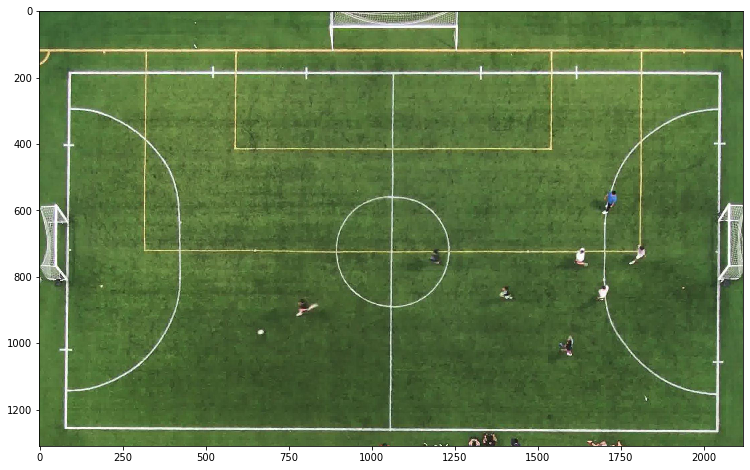

In [38]:
plt.figure(figsize = (20,8))
im = Image.open(null_1['path'][166])
width, height = im.size
plt.imshow(im)
plt.axis("on")


In [0]:
#cat_1 = train_df.loc[train_df['category_id'] == 1]

In [0]:
#cat_1.isna().sum()

In [0]:
#cat_1.tail()

In [0]:
def get_image_dims(arr):
    heights, widths = [], []
    for filename in progress_bar(arr):
        height, width, _ = np.array(keras.preprocessing.image.load_img(filename)).shape
        heights.append(height)
        widths.append(width)
    return np.asarray(heights), np.asarray(widths)

In [40]:
null[["height", "width"]] = pd.DataFrame(get_image_dims(null_1["path"])).T

In [41]:
null.head(10)

,category_id,id,image_id,iscrowd,segmentation,area,bbox,path,height,width
0,4,0,0,0,"[[783.390625, 1969.44921875, 826.3906288146973...",2064.0,"[783.0, 1969.0, 43.0, 48.0]",data/football/images/frame_0001.jpg,1309.0,2118.0
1,4,1,0,0,"[[1140.0, 1984.5, 1110.5, 1984.0, 1111.0, 1940...",1497.0,"[1111.0, 1941.0, 42.0, 44.0]",data/football/images/frame_0002.jpg,1309.0,2118.0
2,4,2,0,0,"[[931.818359375, 1605.4000000000015, 998.0, 16...",3300.0,"[932.0, 1605.0, 66.0, 50.0]",data/football/images/frame_0003.jpg,1309.0,2118.0
3,4,3,0,0,"[[546.30078125, 1719.69921875, 601.20077819824...",2310.0,"[546.0, 1720.0, 55.0, 42.0]",data/football/images/frame_0004.jpg,1309.0,2118.0
4,4,4,0,0,"[[729.6000000000022, 863.2999999999993, 785.79...",3360.0,"[730.0, 863.0, 56.0, 60.0]",data/football/images/frame_0005.jpg,1309.0,2118.0
5,4,5,0,0,"[[773.87109375, 1523.943359375, 828.2187690734...",3024.0,"[774.0, 1524.0, 54.0, 56.0]",data/football/images/frame_0006.jpg,1309.0,2118.0
6,4,6,0,0,"[[1052.300000000001, 1223.1005859375, 1089.399...",2294.0,"[1052.0, 1223.0, 37.0, 62.0]",data/football/images/frame_0007.jpg,1309.0,2118.0
7,4,7,0,0,"[[1909.330078125, 889.22265625, 1945.0, 889.22...",1548.0,"[1909.0, 889.0, 36.0, 43.0]",data/football/images/frame_0008.jpg,1309.0,2118.0
8,4,8,0,0,"[[2024.0, 910.5, 1996.0, 910.5, 1995.5, 886.0,...",700.0,"[1996.0, 886.0, 28.0, 25.0]",data/football/images/frame_0009.jpg,1309.0,2118.0
9,2,9,0,0,"[[2030.2999999999993, 1999.69921875, 2066.8000...",1480.0,"[2030.0, 2000.0, 37.0, 40.0]",data/football/images/frame_0010.jpg,1309.0,2118.0


In [0]:
category_map = null_1.to_dict()['category_id']

In [43]:
category_map

{22: 1,
 46: 1,
 70: 1,
 94: 1,
 118: 1,
 142: 1,
 166: 1,
 190: 1,
 214: 1,
 238: 1,
 262: 1,
 286: 1,
 310: 1,
 334: 1,
 358: 1,
 382: 1,
 406: 1,
 430: 1,
 454: 1,
 478: 1,
 502: 1,
 526: 1,
 550: 1,
 574: 1,
 598: 1,
 622: 1}

In [0]:
BATCH_SIZE = 8
SHUFFLE_SIZE = 256
IMG_DIMS = (71, 71, 3)
N_IMAGES = null_1.shape[0]

In [45]:
null['bbox']

0       [783.0, 1969.0, 43.0, 48.0]
1      [1111.0, 1941.0, 42.0, 44.0]
2       [932.0, 1605.0, 66.0, 50.0]
3       [546.0, 1720.0, 55.0, 42.0]
4        [730.0, 863.0, 56.0, 60.0]
                   ...             
621    [1144.0, 1970.0, 56.0, 37.0]
622    [1155.0, 1911.0, 29.0, 27.0]
623     [782.0, 1970.0, 44.0, 49.0]
624    [1118.0, 1938.0, 50.0, 60.0]
625    [1151.0, 1759.0, 63.0, 32.0]
Name: bbox, Length: 626, dtype: object

In [0]:
train_data, validation_data, test_data = split_df(null, 0.2, "category_id")

In [0]:
train_data, validation_data, test_data = split_df(null_1, 0.4, "category_id")

In [48]:
np.asarray(train_data['bbox'])

array([list([1190.0, 1981.0, 26.0, 20.0]),
       list([1191.0, 1981.0, 25.0, 22.0]),
       list([1195.0, 1983.0, 21.0, 25.0]),
       list([1184.0, 1970.0, 27.0, 26.0]),
       list([1186.0, 1973.0, 27.0, 26.0]),
       list([1184.0, 1968.0, 27.0, 25.0]),
       list([1192.0, 1981.0, 25.0, 24.0]),
       list([1163.0, 1925.0, 21.0, 21.0]),
       list([1184.0, 1967.0, 26.0, 24.0]),
       list([1191.0, 1983.0, 24.0, 22.0]),
       list([1167.0, 1934.0, 24.0, 27.0]),
       list([1187.0, 1975.0, 26.0, 26.0]),
       list([1193.0, 1985.0, 22.0, 22.0]),
       list([1188.0, 1977.0, 26.0, 25.0]),
       list([1193.0, 1982.0, 22.0, 26.0])], dtype=object)

In [0]:
train_data["category_id"]

In [0]:
a = np.array(train_data['bbox'])

In [0]:
a = a.tolist()

In [0]:
train_np_values = np.asarray(a)

In [52]:
train_np_values

array([[1190., 1981.,   26.,   20.],
       [1191., 1981.,   25.,   22.],
       [1195., 1983.,   21.,   25.],
       [1184., 1970.,   27.,   26.],
       [1186., 1973.,   27.,   26.],
       [1184., 1968.,   27.,   25.],
       [1192., 1981.,   25.,   24.],
       [1163., 1925.,   21.,   21.],
       [1184., 1967.,   26.,   24.],
       [1191., 1983.,   24.,   22.],
       [1167., 1934.,   24.,   27.],
       [1187., 1975.,   26.,   26.],
       [1193., 1985.,   22.,   22.],
       [1188., 1977.,   26.,   25.],
       [1193., 1982.,   22.,   26.]])

In [0]:
b = np.array(validation_data['bbox'])

In [0]:
b = b.tolist()

In [0]:
val_np_values = np.asarray(b)

In [0]:
c = np.array(test_data['bbox'])

In [0]:
c = c.tolist()

In [0]:
test_np_values = np.asarray(c)

In [59]:
test_np_values

array([[1179., 1957.,   23.,   24.],
       [1183., 1966.,   26.,   30.],
       [1191., 1977.,   22.,   23.],
       [1189., 1978.,   25.,   25.],
       [1192., 1980.,   25.,   24.],
       [1187., 1970.,   24.,   28.]])

In [0]:
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            train_data["path"],
            tuple(
                [
                    train_data["category_id"].values,
                    train_np_values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "strech"))
    .map(ImageAugmentor(level=3, rotate=False))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
validation_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            validation_data["path"],
            tuple(
                [
                    validation_data["category_id"].values,
                    val_np_values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [0]:
test_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            test_data["path"],
            tuple(
                [
                    test_data["category_id"].values,
                    test_np_values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
def make_rectangle(x0, y0, width, height, img_dims, color, linewidth=2):
    return Rectangle(
        (x0 * img_dims[1], y0 * img_dims[0]),
        width * img_dims[1],
        height * img_dims[0],
        linewidth=linewidth,
        edgecolor=color,
        facecolor="none",
    )

In [64]:
IMG_DIMS

(71, 71, 3)

In [0]:
def get_category_name(category_id: int, with_id: bool = False) -> str:
    return (
        f"{category_id} ({category_map[category_id]})"
        if with_id
        else category_map[category_id]
    )

In [0]:
for x, y in train_set.take(1):
    n_image = 0
    categories, bounding_boxes = y
    category = categories[n_image].numpy()
    bounding_box = bounding_boxes[n_image].numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(x[n_image].numpy())
    plt.text(
        bounding_box[0] * IMG_DIMS[0],
        bounding_box[1] * IMG_DIMS[1],
        get_category_name(category),
        backgroundcolor="red",
        fontsize=12,
    )
    y_rect = make_rectangle(*bounding_box, IMG_DIMS, "r")
    ax.add_patch(y_rect)
    plt.show()

In [0]:
train_set

<PrefetchDataset shapes: ((None, None, None, 3), ((None,), (None, 4))), types: (tf.float32, (tf.int64, tf.float64))>

In [0]:
class GlobalConcatPooling2D(keras.layers.Layer):
    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        return keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(layer),
                keras.layers.GlobalMaxPool2D()(layer),
            ]
        )



In [0]:
def make_model():
    base = tf.keras.applications.Xception(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
    x = GlobalConcatPooling2D()(base.output)
    x = keras.layers.Dropout(0.2)(x)
    category = keras.layers.Dense(n_categories, activation=keras.activations.softmax)(x)
    bounding_box = keras.layers.Dense(4, activation=keras.activations.sigmoid)(x)
    model = keras.Model(inputs=base.input, outputs=[category, bounding_box])
    model.compile(
        loss=[
            keras.losses.SparseCategoricalCrossentropy(),
            keras.losses.BinaryCrossentropy(),
        ],
        loss_weights=[0.5, 2.0],
        optimizer=keras.optimizers.Adam(3e-4),
    )
    return model

In [0]:
n_categories = train_data["category_id"].nunique()

In [69]:
n_categories

1

In [70]:
model = make_model()

83689472/83683744 [==============================] - 3s 0us/step


In [71]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
model.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_data.shape[0] / BATCH_SIZE),
    epochs=5,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            str(TEMP_DIR / "model3.h5"), save_best_only=True, save_weights_only=True
        ),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 2 steps, validate for 1 steps
Epoch 1/5
